# AirBnB Fair Valuation

Welcome to Airbnb Analysis Corp.! Your task is to set the competitive **daily accomodation rate** for a client's house in Bondi Beach. The owner currently charges $500. We have been tasked to estimate a **fair value** that the owner should be charging. The house has the following characteristics and constraints. While developing this model you came to realise that Airbnb can use your model to estimate the fair value of any property on their database, your are effectively creating a recommendation model for all prospective hosts!


1. The owner has been a host since **August 2010**
1. The location is **lon:151.274506, lat:33.889087**
1. The current review score rating **95.0**
1. Number of reviews **53**
1. Minimum nights **4**
1. The house can accomodate **10** people.
1. The owner currently charges a cleaning fee of **370**
1. The house has **3 bathrooms, 5 bedrooms, 7 beds**.
1. The house is available for **255 of the next 365 days**
1. The client is **verified**, and they are a **superhost**.
1. The cancelation policy is **strict with a 14 days grace period**.
1. The host requires a security deposit of **$1,500**


*All values strictly apply to the month of July 2018*

In [ ]:
from dateutil import parser
dict_client = {}

dict_client["city"] = "Bondi Beach"
dict_client["longitude"] = 151.274506
dict_client["latitude"] = -33.889087
dict_client["review_scores_rating"] = 95
dict_client["number_of_reviews"] = 53
dict_client["minimum_nights"] = 4
dict_client["accommodates"] = 10
dict_client["bathrooms"] = 3
dict_client["bedrooms"] = 5
dict_client["beds"] = 7
dict_client["security_deposit"] = 1500
dict_client["cleaning_fee"] = 370
dict_client["property_type"] = "House"
dict_client["room_type"] = "Entire home/apt"
dict_client["availability_365"] = 255
dict_client["host_identity_verified"] = 1  ## 1 for yes, 0 for no
dict_client["host_is_superhost"] = 1
dict_client["cancellation_policy"] = "strict_14_with_grace_period"
dict_client["host_since"] = parser.parse("01-08-2010")



## Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [ ]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals
# Common imports
import numpy as np
import os
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    try:
        plt.savefig(path, format=fig_extension, dpi=resolution)
    except:
        plt.savefig(fig_id + "." + fig_extension, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")
pd.options.display.max_columns = None

## Get the data

In [ ]:
## This is simply a bit of importing logic that you don't have ..
## .. to concern yourself with for now. 

from pathlib import Path

github_p = "https://raw.githubusercontent.com/Finance-781/FinML/master/Lecture%202%20-%20End-to-End%20ML%20Project%20/Practice/"

my_file = Path("datasets/sydney_airbnb.csv") # Defines path
if my_file.is_file():              # See if file exists
    print("Local file found")      
    df = pd.read_csv('datasets/sydney_airbnb.csv')
else:
    print("Be patient: loading from github (2 minutes)")
    df = pd.read_csv(github_p+'datasets/sydney_airbnb.csv')
    print("Done")

Be patient: loading from github (2 minutes)
Done


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (36,54,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
### To make this project easier, I will select only a small number of features

In [ ]:
incl = ["price","city","longitude","latitude","review_scores_rating","number_of_reviews","minimum_nights","security_deposit","cleaning_fee","accommodates","bathrooms","bedrooms","beds","property_type","room_type","availability_365" ,"host_identity_verified", "host_is_superhost","host_since","cancellation_policy"] 

In [ ]:
df = df[incl]

Lets reformat the price to floats, it is currently a string (object). And lets makes sure the date is in a datetime format.

In [ ]:
import re
price_list = ["price","cleaning_fee","security_deposit"]

for col in price_list:
    df[col] = df[col].fillna("0")
    df[col] = df[col].apply(lambda x: float(re.compile('[^0-9eE.]').sub('', x)) if len(x)>0 else 0)

df['host_since'] = pd.to_datetime(df['host_since'])

In [ ]:
df["price"].head()

0     65.0
1     98.0
2    469.0
3     63.0
4     39.0
Name: price, dtype: float64

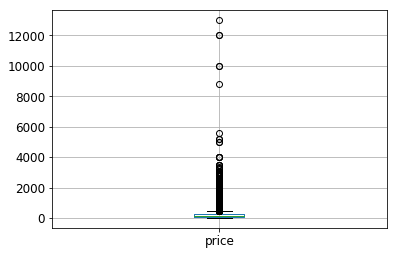

In [ ]:
## Winsorize for high price values, outliers.

df.boxplot(column="price")

In [ ]:
## this is high, because we have a price we expect it to be high.
## however, it shouldn't be much above 3. 
df["price"].skew()

13.808558337216192

In [ ]:
## This value is still relatively high
df["price"].quantile(0.995) ## @99.5% 

1600.0

In [ ]:
df = df[df["price"]<df["price"].quantile(0.995)].reset_index(drop=True)

In [ ]:
## This would do for now, it might also be worth transforming ..
## .. the price with a log function at a later stage
df["price"].skew()

2.957872457159033

In [ ]:
df.isnull().sum()

price                        0
city                        32
longitude                    0
latitude                     0
review_scores_rating      7466
number_of_reviews            0
minimum_nights               0
security_deposit             0
cleaning_fee                 0
accommodates                 0
bathrooms                   22
bedrooms                     8
beds                        33
property_type                0
room_type                    0
availability_365             0
host_identity_verified      34
host_is_superhost           34
host_since                  34
cancellation_policy          0
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26931 entries, 0 to 26930
Data columns (total 20 columns):
price                     26931 non-null float64
city                      26899 non-null object
longitude                 26931 non-null float64
latitude                  26931 non-null float64
review_scores_rating      19465 non-null float64
number_of_reviews         26931 non-null int64
minimum_nights            26931 non-null int64
security_deposit          26931 non-null float64
cleaning_fee              26931 non-null float64
accommodates              26931 non-null int64
bathrooms                 26909 non-null float64
bedrooms                  26923 non-null float64
beds                      26898 non-null float64
property_type             26931 non-null object
room_type                 26931 non-null object
availability_365          26931 non-null int64
host_identity_verified    26897 non-null object
host_is_superhost         26897 non-null object
host_since            

In [ ]:
df["cancellation_policy"].value_counts()

strict_14_with_grace_period    11585
flexible                        8538
moderate                        6776
super_strict_60                   31
super_strict_30                    1
Name: cancellation_policy, dtype: int64

In [ ]:
df.describe()

,price,longitude,latitude,review_scores_rating,number_of_reviews,minimum_nights,security_deposit,cleaning_fee,accommodates,bathrooms,bedrooms,beds,availability_365
count,26931.000000,26931.000000,26931.000000,19465.000000,26931.000000,26931.000000,26931.000000,26931.000000,26931.000000,26909.000000,26923.000000,26898.000000,26931.000000
mean,196.065464,151.210438,-33.862675,93.404932,14.070031,4.482010,293.870261,65.268687,3.357395,1.340964,1.600787,1.996542,101.575916
std,199.813830,0.079425,0.071861,9.358515,29.870227,14.421896,549.642202,84.886663,2.160004,0.638187,1.091213,1.506535,127.822623
min,0.000000,150.644964,-34.135212,20.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,80.000000,151.184336,-33.897653,90.000000,1.000000,1.000000,0.000000,0.000000,2.000000,1.000000,1.000000,1.000000,0.000000
50%,132.000000,151.223029,-33.883161,96.000000,3.000000,2.000000,0.000000,40.000000,2.000000,1.000000,1.000000,1.000000,32.000000
75%,225.000000,151.264706,-33.832189,100.000000,13.000000,5.000000,400.000000,99.000000,4.000000,1.500000,2.000000,2.000000,179.000000
max,1599.000000,151.339811,-33.389728,100.000000,468.000000,1000.000000,7000.000000,999.000000,16.000000,10.000000,46.000000,29.000000,365.000000


Saving figure attribute_histogram_plots


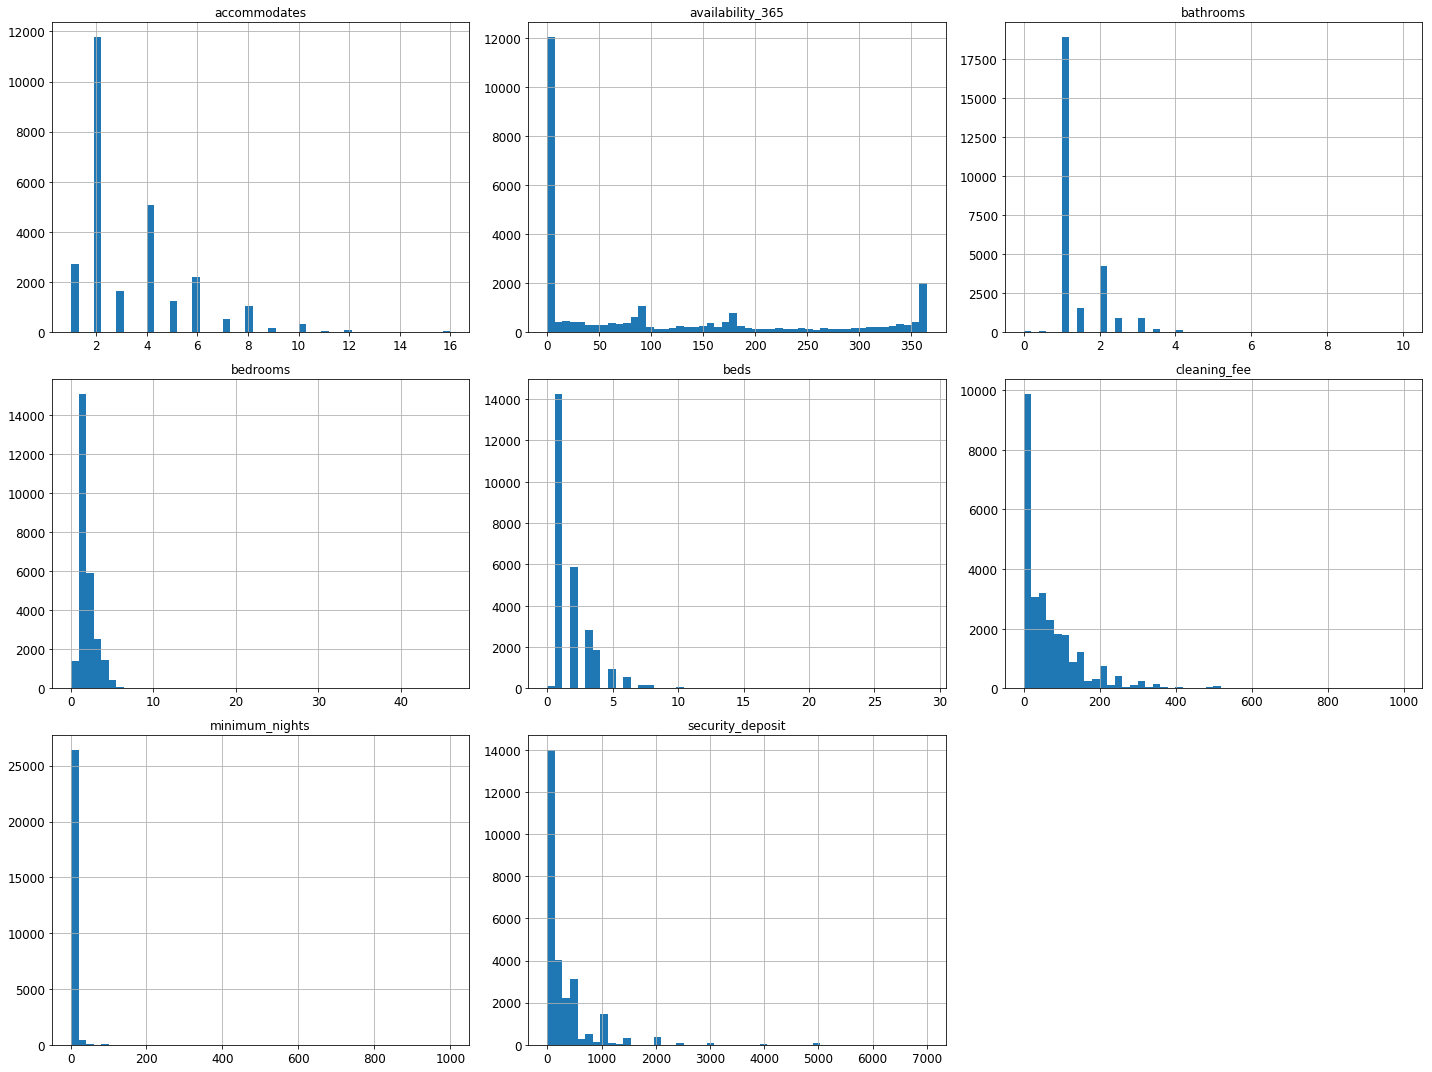

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

try:
    df.iloc[:,6:].hist(bins=50, figsize=(20,15))
    save_fig("attribute_histogram_plots")
    plt.show()
except AttributeError:
    pass


In [ ]:
## Even though our customer, sepecifcally wants information about..
## .. Bondi the addition of other areas will help the final prediction

df["city"].value_counts().head(10)

Bondi Beach     1671
Manly            958
Surry Hills      919
Bondi            785
Randwick         684
Sydney           682
Coogee           675
Darlinghurst     660
North Bondi      629
Newtown          490
Name: city, dtype: int64

In [ ]:
## For this taks we will keep the top 20 Sydney locations

list_of_20 = list(df["city"].value_counts().head(10).index)
df = df[df["city"].isin(list_of_20)].reset_index(drop=True)

In [ ]:
df["property_type"].value_counts()

Apartment             5970
House                 1497
Townhouse              271
Condominium            115
Loft                    59
Guest suite             44
Other                   33
Hostel                  30
Bed and breakfast       25
Guesthouse              24
Serviced apartment      23
Villa                   16
Bungalow                 7
Boutique hotel           6
Cottage                  6
Tent                     6
Tiny house               5
Resort                   5
Hotel                    3
Cabin                    2
Aparthotel               1
Earth house              1
Chalet                   1
Houseboat                1
Yurt                     1
Camper/RV                1
Name: property_type, dtype: int64

In [ ]:
## Remove rare occurences in categories as is necessary for..
## .. the eventaul cross validation step, the below step is somewhat ..
## .. similar for what has been done with cities above

item_counts = df.groupby(['property_type']).size()
rare_items = list(item_counts.loc[item_counts <= 10].index.values)

In [ ]:
df = df[~df["property_type"].isin(rare_items)].reset_index(drop=True)

In [ ]:
# to make this notebook's output identical at every run
np.random.seed(42)

In [ ]:
import numpy as np

# For illustration only. Sklearn has train_test_split()
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [ ]:
train_set, test_set = split_train_test(df, 0.2)
print(len(train_set), "train +", len(test_set), "test")

6486 train + 1621 test


In [ ]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

The implementation of `test_set_check()` above works fine in both Python 2 and Python 3. In earlier releases, the following implementation was proposed, which supported any hash function, but was much slower and did not support Python 2:

In [ ]:
import hashlib

def test_set_check(identifier, test_ratio, hash=hashlib.md5):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

If you want an implementation that supports any hash function and is compatible with both Python 2 and Python 3, here is one:

In [ ]:
def test_set_check(identifier, test_ratio, hash=hashlib.md5):
    return bytearray(hash(np.int64(identifier)).digest())[-1] < 256 * test_ratio

In [ ]:
df_with_id = df.reset_index()   # adds an `index` column
train_set, test_set = split_train_test_by_id(df_with_id, 0.2, "index")

In [ ]:
df_with_id["id"] = df["longitude"] * 1000 + df_with_id["latitude"]
train_set, test_set = split_train_test_by_id(df_with_id, 0.2, "id")

In [ ]:
test_set.head()

,index,price,city,longitude,latitude,review_scores_rating,number_of_reviews,minimum_nights,security_deposit,cleaning_fee,accommodates,bathrooms,bedrooms,beds,property_type,room_type,availability_365,host_identity_verified,host_is_superhost,host_since,cancellation_policy,id
0,0,111.0,Darlinghurst,151.216541,-33.880455,88.0,272,2,0.0,0.0,2,1.0,1.0,1.0,Apartment,Private room,285,t,f,2009-03-12,strict_14_with_grace_period,151182.660345
4,4,130.0,Bondi Beach,151.273084,-33.891846,95.0,119,4,200.0,60.0,2,1.0,1.0,1.0,Apartment,Entire home/apt,94,t,t,2012-01-18,strict_14_with_grace_period,151239.192454
5,5,111.0,Sydney,151.268865,-33.885690,89.0,11,4,0.0,100.0,4,1.0,2.0,2.0,Apartment,Entire home/apt,14,f,f,2010-12-14,strict_14_with_grace_period,151234.979210
9,9,990.0,Coogee,151.260116,-33.914816,98.0,13,7,3000.0,0.0,12,5.0,6.0,6.0,Villa,Entire home/apt,33,t,f,2011-10-02,strict_14_with_grace_period,151226.201484
12,12,202.0,Bondi,151.268418,-33.895158,91.0,90,1,1000.0,150.0,4,1.0,2.0,2.0,Apartment,Entire home/apt,204,f,f,2011-03-31,strict_14_with_grace_period,151234.523342


In [ ]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
test_set.head()

,price,city,longitude,latitude,review_scores_rating,number_of_reviews,minimum_nights,security_deposit,cleaning_fee,accommodates,bathrooms,bedrooms,beds,property_type,room_type,availability_365,host_identity_verified,host_is_superhost,host_since,cancellation_policy
4084,68.0,North Bondi,151.279684,-33.884092,93.0,3,7,150.0,0.0,2,2.5,1.0,1.0,House,Private room,4,t,f,2016-08-18,strict_14_with_grace_period
965,128.0,Surry Hills,151.212610,-33.891416,100.0,4,5,690.0,99.0,4,1.0,2.0,2.0,Townhouse,Entire home/apt,173,t,t,2014-10-31,moderate
8100,115.0,Darlinghurst,151.217882,-33.874271,98.0,8,2,0.0,30.0,3,1.0,1.0,1.0,Apartment,Entire home/apt,12,f,f,2017-04-02,moderate
3882,125.0,Sydney,151.204837,-33.875924,NaN,0,2,150.0,50.0,4,1.0,1.0,3.0,Other,Shared room,363,f,f,2014-12-01,flexible
1010,250.0,North Bondi,151.274298,-33.885652,100.0,4,2,0.0,80.0,2,1.0,1.0,1.0,Apartment,Entire home/apt,363,t,f,2012-09-29,strict_14_with_grace_period


The models that would be used in this project can't read textual data, thus we have to turn text categories into numeric categories. The code below will create city codes, this time for the purpose of statified sampeing. 


In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

for col in ["city"]:
    df[col+"_code"] = le.fit_transform(df[col])


In [ ]:
##  Similar to above encoding, here we encode binary 1, 0 for t and f. 

df["host_identity_verified"] = df["host_identity_verified"].apply(lambda x: 1 if x=="t" else 0)
df["host_is_superhost"] = df["host_is_superhost"].apply(lambda x: 1 if x=="t" else 0)


In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

## we will stratify according to city

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df["city_code"]):
    del df["city_code"]
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

In [ ]:
## Average price per area
strat_test_set.groupby("city")["price"].mean()

city
Bondi           198.745223
Bondi Beach     199.879880
Coogee          196.574627
Darlinghurst    184.700000
Manly           223.447368
Newtown         117.938776
North Bondi     248.857143
Randwick        178.072993
Surry Hills     175.732240
Sydney          193.962687
Name: price, dtype: float64

## Discover and visualize the data to gain insights

In [ ]:
traval = strat_train_set.copy() ##traval - training and validation set

Saving figure bad_visualization_plot


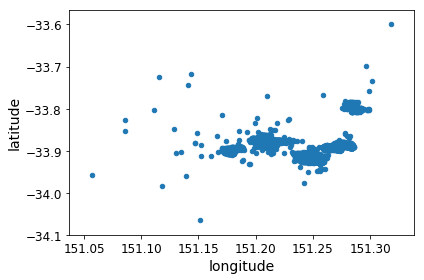

In [ ]:
traval.plot(kind="scatter", x="longitude", y="latitude")
save_fig("bad_visualization_plot")

Saving figure better_visualization_plot


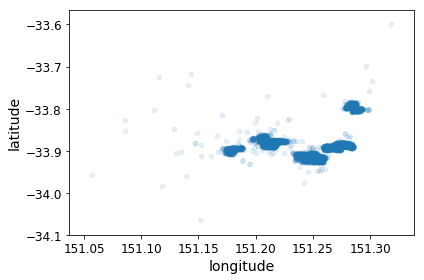

In [ ]:
traval.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
save_fig("better_visualization_plot")

The argument `sharex=False` fixes a display bug (the x-axis values and legend were not displayed). This is a temporary fix (see: https://github.com/pandas-dev/pandas/issues/10611). Thanks to Wilmer Arellano for pointing it out.

In [ ]:
traval_co = traval[(traval["longitude"]>151.16)&(traval["latitude"]<-33.75)].reset_index(drop=True)

traval_co = traval_co[traval_co["latitude"]>-33.95].reset_index(drop=True)

traval_co = traval_co[traval_co["price"]<600].reset_index(drop=True)

Saving figure housing_prices_scatterplot


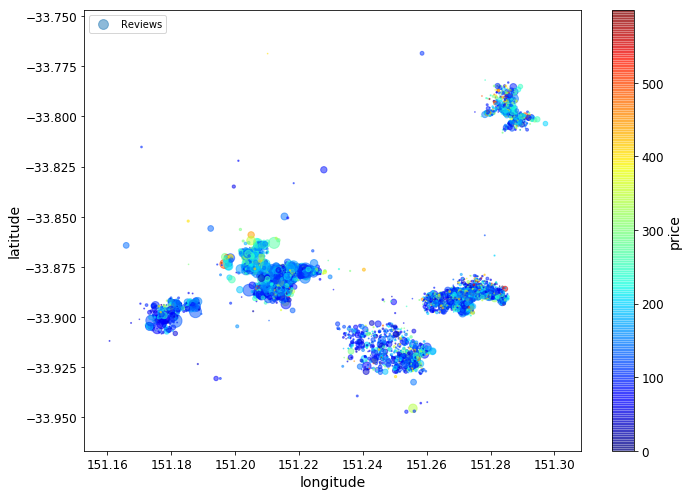

In [ ]:
traval_co.plot(kind="scatter", x="longitude", y="latitude", alpha=0.5,
    s=traval_co["number_of_reviews"]/2, label="Reviews", figsize=(10,7),
    c="price", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()
save_fig("housing_prices_scatterplot")

In [ ]:
corr_matrix = traval.corr()

In [ ]:
corr_matrix["price"].sort_values(ascending=False)

price                     1.000000
accommodates              0.674368
bedrooms                  0.668963
beds                      0.582378
bathrooms                 0.553773
cleaning_fee              0.529834
security_deposit          0.469423
longitude                 0.157902
availability_365          0.148263
latitude                  0.131160
review_scores_rating      0.067066
host_identity_verified    0.048821
minimum_nights            0.022103
host_is_superhost        -0.016695
number_of_reviews        -0.064011
Name: price, dtype: float64

Saving figure scatter_matrix_plot


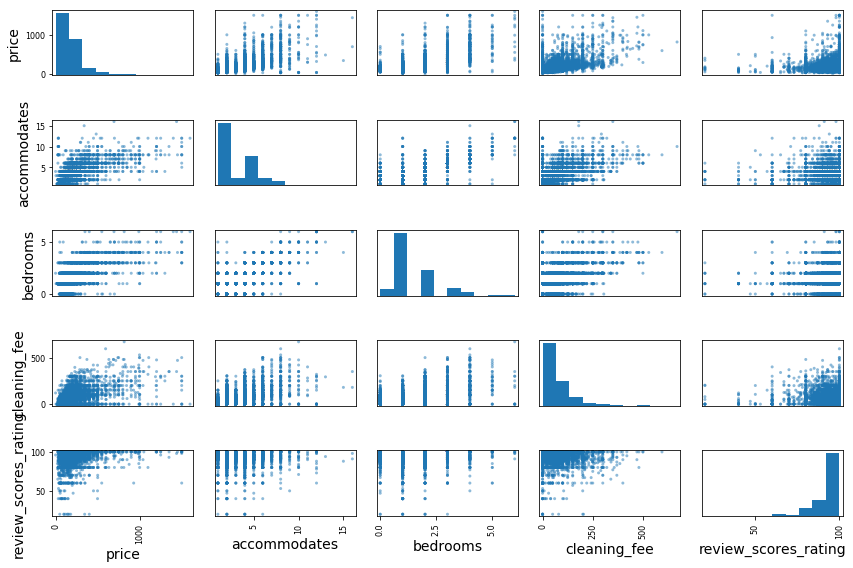

In [ ]:
# from pandas.tools.plotting import scatter_matrix # For older versions of Pandas
from pandas.plotting import scatter_matrix

attributes = ["price", "accommodates", "bedrooms",
              "cleaning_fee","review_scores_rating"]
scatter_matrix(traval[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

Saving figure income_vs_house_value_scatterplot


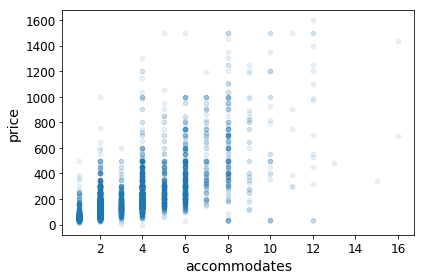

In [ ]:
traval.plot(kind="scatter", x="accommodates", y="price",
             alpha=0.1)
save_fig("income_vs_house_value_scatterplot")

In [ ]:
traval.head()

,price,city,longitude,latitude,review_scores_rating,number_of_reviews,minimum_nights,security_deposit,cleaning_fee,accommodates,bathrooms,bedrooms,beds,property_type,room_type,availability_365,host_identity_verified,host_is_superhost,host_since,cancellation_policy
5484,200.0,Newtown,151.178552,-33.907150,96.0,61,2,250.0,85.0,4,1.0,2.0,2.0,House,Entire home/apt,127,1,0,2016-01-22,moderate
1267,183.0,Randwick,151.249030,-33.906190,97.0,6,4,0.0,20.0,2,1.0,1.0,1.0,Apartment,Private room,0,1,0,2014-03-28,moderate
6658,175.0,Manly,151.288491,-33.802074,100.0,2,2,0.0,40.0,2,1.0,1.0,1.0,Apartment,Entire home/apt,0,1,0,2014-01-09,strict_14_with_grace_period
2522,85.0,Randwick,151.236423,-33.913614,94.0,20,3,0.0,0.0,2,1.0,1.0,1.0,Apartment,Private room,90,0,0,2015-11-22,flexible
722,80.0,Coogee,151.259342,-33.918435,92.0,139,30,0.0,0.0,3,1.0,1.0,2.0,Apartment,Private room,0,1,0,2014-01-07,strict_14_with_grace_period


In [ ]:
#### Some Feature Engineering

In [ ]:
traval["bedrooms_per_person"] = traval["bedrooms"]/traval["accommodates"]
traval["bathrooms_per_person"] = traval["bathrooms"]/traval["accommodates"]
traval['host_since'] = pd.to_datetime(traval['host_since'])
traval['days_on_airbnb'] = (pd.to_datetime('today') - traval['host_since']).dt.days

## Prepare the data for Machine Learning algorithms

In [ ]:
## Here I will forget about traval and use a more formal way of introducing...
## ..preprocessin using pipelines

In [ ]:
X  = traval.copy().drop("price", axis=1) # drop labels for training set

In [ ]:
sample_incomplete_rows = X[X.isnull().any(axis=1)].head()
print(sample_incomplete_rows.shape)
sample_incomplete_rows

(5, 22)


,city,longitude,latitude,review_scores_rating,number_of_reviews,minimum_nights,security_deposit,cleaning_fee,accommodates,bathrooms,bedrooms,beds,property_type,room_type,availability_365,host_identity_verified,host_is_superhost,host_since,cancellation_policy,bedrooms_per_person,bathrooms_per_person,days_on_airbnb
5594,Randwick,151.238806,-33.913834,NaN,0,2,800.0,80.0,6,1.0,3.0,3.0,House,Entire home/apt,0,0,0,2013-11-27,moderate,0.500000,0.166667,2064.0
5439,Newtown,151.184469,-33.894582,NaN,0,3,5000.0,100.0,11,2.0,3.0,4.0,Apartment,Entire home/apt,0,1,0,2014-07-16,strict_14_with_grace_period,0.272727,0.181818,1833.0
3847,Bondi Beach,151.273077,-33.895142,NaN,0,7,271.0,27.0,2,1.0,1.0,1.0,Apartment,Private room,0,0,0,2015-12-07,strict_14_with_grace_period,0.500000,0.500000,1324.0
1312,Randwick,151.245793,-33.920622,NaN,0,3,0.0,80.0,3,1.0,2.0,2.0,Apartment,Entire home/apt,0,0,0,2015-10-02,strict_14_with_grace_period,0.666667,0.333333,1390.0
6194,Bondi Beach,151.273411,-33.888113,NaN,0,10,0.0,0.0,2,1.0,1.0,1.0,Apartment,Private room,0,1,0,2015-08-14,moderate,0.500000,0.500000,1439.0


In [ ]:
# Rows Remove
sample_incomplete_rows.dropna(subset=["review_scores_rating"])    # option 1

,city,longitude,latitude,review_scores_rating,number_of_reviews,minimum_nights,security_deposit,cleaning_fee,accommodates,bathrooms,bedrooms,beds,property_type,room_type,availability_365,host_identity_verified,host_is_superhost,host_since,cancellation_policy,bedrooms_per_person,bathrooms_per_person,days_on_airbnb


In [ ]:
# Columns Remove
sample_incomplete_rows.drop(["review_scores_rating"], axis=1)       # option 2

,city,longitude,latitude,number_of_reviews,minimum_nights,security_deposit,cleaning_fee,accommodates,bathrooms,bedrooms,beds,property_type,room_type,availability_365,host_identity_verified,host_is_superhost,host_since,cancellation_policy,bedrooms_per_person,bathrooms_per_person,days_on_airbnb
5594,Randwick,151.238806,-33.913834,0,2,800.0,80.0,6,1.0,3.0,3.0,House,Entire home/apt,0,0,0,2013-11-27,moderate,0.500000,0.166667,2064.0
5439,Newtown,151.184469,-33.894582,0,3,5000.0,100.0,11,2.0,3.0,4.0,Apartment,Entire home/apt,0,1,0,2014-07-16,strict_14_with_grace_period,0.272727,0.181818,1833.0
3847,Bondi Beach,151.273077,-33.895142,0,7,271.0,27.0,2,1.0,1.0,1.0,Apartment,Private room,0,0,0,2015-12-07,strict_14_with_grace_period,0.500000,0.500000,1324.0
1312,Randwick,151.245793,-33.920622,0,3,0.0,80.0,3,1.0,2.0,2.0,Apartment,Entire home/apt,0,0,0,2015-10-02,strict_14_with_grace_period,0.666667,0.333333,1390.0
6194,Bondi Beach,151.273411,-33.888113,0,10,0.0,0.0,2,1.0,1.0,1.0,Apartment,Private room,0,1,0,2015-08-14,moderate,0.500000,0.500000,1439.0


In [ ]:
median = X["review_scores_rating"].median()
sample_incomplete_rows["review_scores_rating"].fillna(median, inplace=True) # option 3

sample_incomplete_rows

,city,longitude,latitude,review_scores_rating,number_of_reviews,minimum_nights,security_deposit,cleaning_fee,accommodates,bathrooms,bedrooms,beds,property_type,room_type,availability_365,host_identity_verified,host_is_superhost,host_since,cancellation_policy,bedrooms_per_person,bathrooms_per_person,days_on_airbnb
5594,Randwick,151.238806,-33.913834,96.0,0,2,800.0,80.0,6,1.0,3.0,3.0,House,Entire home/apt,0,0,0,2013-11-27,moderate,0.500000,0.166667,2064.0
5439,Newtown,151.184469,-33.894582,96.0,0,3,5000.0,100.0,11,2.0,3.0,4.0,Apartment,Entire home/apt,0,1,0,2014-07-16,strict_14_with_grace_period,0.272727,0.181818,1833.0
3847,Bondi Beach,151.273077,-33.895142,96.0,0,7,271.0,27.0,2,1.0,1.0,1.0,Apartment,Private room,0,0,0,2015-12-07,strict_14_with_grace_period,0.500000,0.500000,1324.0
1312,Randwick,151.245793,-33.920622,96.0,0,3,0.0,80.0,3,1.0,2.0,2.0,Apartment,Entire home/apt,0,0,0,2015-10-02,strict_14_with_grace_period,0.666667,0.333333,1390.0
6194,Bondi Beach,151.273411,-33.888113,96.0,0,10,0.0,0.0,2,1.0,1.0,1.0,Apartment,Private room,0,1,0,2015-08-14,moderate,0.500000,0.500000,1439.0


In [ ]:
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy="median")

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Remove the text attribute because median can only be calculated on numerical attributes:

In [ ]:
cat_cols = ["city","cancellation_policy","host_since","room_type","property_type","host_since"]
X_num = X.drop(cat_cols, axis=1)
# alternatively: X_num = X.select_dtypes(include=[int, float])

In [ ]:
imputer.fit(X_num)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

In [ ]:
imputer.statistics_

array([ 1.51259665e+02, -3.38885369e+01,  9.60000000e+01,  3.00000000e+00,
        3.00000000e+00,  0.00000000e+00,  5.00000000e+01,  2.00000000e+00,
        1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  4.00000000e+00,
        1.00000000e+00,  0.00000000e+00,  5.00000000e-01,  5.00000000e-01,
        1.70400000e+03])

Check that this is the same as manually computing the median of each attribute:

In [ ]:
X_num.median().values

array([ 1.51259665e+02, -3.38885369e+01,  9.60000000e+01,  3.00000000e+00,
        3.00000000e+00,  0.00000000e+00,  5.00000000e+01,  2.00000000e+00,
        1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  4.00000000e+00,
        1.00000000e+00,  0.00000000e+00,  5.00000000e-01,  5.00000000e-01,
        1.70400000e+03])

Transform the training set:

In [ ]:
X_num_np = imputer.transform(X_num)

In [ ]:
X_num = pd.DataFrame(X_num_np, columns=X_num.columns,
                          index = list(X_num.index.values))

In [ ]:
X_num.loc[sample_incomplete_rows.index.values]

,longitude,latitude,review_scores_rating,number_of_reviews,minimum_nights,security_deposit,cleaning_fee,accommodates,bathrooms,bedrooms,beds,availability_365,host_identity_verified,host_is_superhost,bedrooms_per_person,bathrooms_per_person,days_on_airbnb
5594,151.238806,-33.913834,96.0,0.0,2.0,800.0,80.0,6.0,1.0,3.0,3.0,0.0,0.0,0.0,0.500000,0.166667,2064.0
5439,151.184469,-33.894582,96.0,0.0,3.0,5000.0,100.0,11.0,2.0,3.0,4.0,0.0,1.0,0.0,0.272727,0.181818,1833.0
3847,151.273077,-33.895142,96.0,0.0,7.0,271.0,27.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.500000,0.500000,1324.0
1312,151.245793,-33.920622,96.0,0.0,3.0,0.0,80.0,3.0,1.0,2.0,2.0,0.0,0.0,0.0,0.666667,0.333333,1390.0
6194,151.273411,-33.888113,96.0,0.0,10.0,0.0,0.0,2.0,1.0,1.0,1.0,0.0,1.0,0.0,0.500000,0.500000,1439.0


In [ ]:
imputer.strategy

'median'

Now let's preprocess the categorical input feature, `ocean_proximity`:

In [ ]:
X_cat = X.select_dtypes(include=[object])
X_cat.head(10)

,city,property_type,room_type,cancellation_policy
5484,Newtown,House,Entire home/apt,moderate
1267,Randwick,Apartment,Private room,moderate
6658,Manly,Apartment,Entire home/apt,strict_14_with_grace_period
2522,Randwick,Apartment,Private room,flexible
722,Coogee,Apartment,Private room,strict_14_with_grace_period
3150,Manly,Apartment,Entire home/apt,strict_14_with_grace_period
2865,Surry Hills,Apartment,Entire home/apt,strict_14_with_grace_period
4906,Bondi Beach,Apartment,Entire home/apt,strict_14_with_grace_period
575,Coogee,Apartment,Entire home/apt,strict_14_with_grace_period
5827,Newtown,House,Private room,flexible


In [ ]:
from sklearn.preprocessing import OrdinalEncoder

In [ ]:
X_cat.head()

,city,property_type,room_type,cancellation_policy
5484,Newtown,House,Entire home/apt,moderate
1267,Randwick,Apartment,Private room,moderate
6658,Manly,Apartment,Entire home/apt,strict_14_with_grace_period
2522,Randwick,Apartment,Private room,flexible
722,Coogee,Apartment,Private room,strict_14_with_grace_period


In [ ]:
ordinal_encoder = OrdinalEncoder()
X_cat_enc = ordinal_encoder.fit_transform(X_cat)
X_cat_enc[:10]

array([[5., 6., 0., 1.],
       [7., 0., 1., 1.],
       [4., 0., 0., 2.],
       [7., 0., 1., 0.],
       [2., 0., 1., 2.],
       [4., 0., 0., 2.],
       [8., 0., 0., 2.],
       [1., 0., 0., 2.],
       [2., 0., 0., 2.],
       [5., 6., 1., 0.]])

In [ ]:
ordinal_encoder.categories_

[array(['Bondi', 'Bondi Beach', 'Coogee', 'Darlinghurst', 'Manly',
        'Newtown', 'North Bondi', 'Randwick', 'Surry Hills', 'Sydney'],
       dtype=object),
 array(['Apartment', 'Bed and breakfast', 'Condominium', 'Guest suite',
        'Guesthouse', 'Hostel', 'House', 'Loft', 'Other',
        'Serviced apartment', 'Townhouse', 'Villa'], dtype=object),
 array(['Entire home/apt', 'Private room', 'Shared room'], dtype=object),
 array(['flexible', 'moderate', 'strict_14_with_grace_period',
        'super_strict_60'], dtype=object)]

In [ ]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
X_cat_1hot = cat_encoder.fit_transform(X_cat)
X_cat_1hot

<6485x29 sparse matrix of type '<class 'numpy.float64'>'
	with 25940 stored elements in Compressed Sparse Row format>

By default, the `OneHotEncoder` class returns a sparse array, but we can convert it to a dense array if needed by calling the `toarray()` method:

In [ ]:
X_cat_1hot.toarray()

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 1., 0.]])

Alternatively, you can set `sparse=False` when creating the `OneHotEncoder`:

In [ ]:
cat_encoder = OneHotEncoder(sparse=False)
X_cat_1hot = cat_encoder.fit_transform(X_cat)
X_cat_1hot

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 1., 0.]])

In [ ]:
cat_encoder.categories_

[array(['Bondi', 'Bondi Beach', 'Coogee', 'Darlinghurst', 'Manly',
        'Newtown', 'North Bondi', 'Randwick', 'Surry Hills', 'Sydney'],
       dtype=object),
 array(['Apartment', 'Bed and breakfast', 'Condominium', 'Guest suite',
        'Guesthouse', 'Hostel', 'House', 'Loft', 'Other',
        'Serviced apartment', 'Townhouse', 'Villa'], dtype=object),
 array(['Entire home/apt', 'Private room', 'Shared room'], dtype=object),
 array(['flexible', 'moderate', 'strict_14_with_grace_period',
        'super_strict_60'], dtype=object)]

Let's create a custom transformer to add extra attributes:

**Now let's create a pipeline for preprocessing that is built on the techniques we used up and till now and introduce some new pipeline techniques.**

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from datetime import datetime
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

# Receive numpy array, convert to pandas for features, convert back to array for output.

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, popularity = True, num_cols=[]): # no *args or **kargs
        self.popularity = popularity
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        
        ### Some feature engineering
        X = pd.DataFrame(X, columns=num_cols)
        X["bedrooms_per_person"] = X["bedrooms"]/X["accommodates"]
        X["bathrooms_per_person"] = X["bathrooms"]/X["accommodates"]
        
        global feats
        feats = ["bedrooms_per_person","bathrooms_per_person"]

        if self.popularity:
            X["past_and_future_popularity"]=X["number_of_reviews"]/(X["availability_365"]+1)
            feats.append("past_and_future_popularity")
            
            return X.values
        else:
            return X.values
        

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

X = strat_train_set.copy().drop("price",axis=1)
Y = strat_train_set["price"]

num_cols = list(X.select_dtypes(include=numerics).columns)
cat_cols = list(X.select_dtypes(include=[object]).columns)

num_pipeline = Pipeline([
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder(num_cols=num_cols,popularity=True)),
        ('std_scaler', StandardScaler()),
    ])

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


**Warning**: earlier versions of the book applied different transformations to different columns using a solution based on a `DataFrameSelector` transformer and a `FeatureUnion` (see below). It is now preferable to use the `ColumnTransformer` class that will is introduced in Scikit-Learn 0.20. 

In [ ]:
from sklearn.compose import ColumnTransformer
import itertools


numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

mid_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_cols),
        ("cat", OneHotEncoder(),cat_cols ),
    ])

In [ ]:
mid_pipeline.fit(X) # this one specifically has to be fitted for the cat names
cat_encoder = mid_pipeline.named_transformers_["cat"]
sublists = [list(bas) for bas in cat_encoder.categories_]
one_cols = list(itertools.chain(*sublists))

## In this class, I will be converting numpy back to pandas

class ToPandasDF(BaseEstimator, TransformerMixin):
    def __init__(self, fit_index = [] ): # no *args or **kargs
        self.fit_index = fit_index
    def fit(self, X_df, y=None):
        return self  # nothing else to do
    def transform(self, X_df, y=None):
        global cols
        cols = num_cols.copy()
        cols.extend(feats)
        cols.extend(one_cols) # one in place of cat
        X_df = pd.DataFrame(X_df, columns=cols,index=self.fit_index)

        return X_df

def pipe(inds):
    return Pipeline([
            ("mid", mid_pipeline),
            ("PD", ToPandasDF(inds)),
        ])
    
params = {"inds" : list(X.index)}

X_pr = pipe(**params).fit_transform(X) # Now we have done all the preprocessing instead of
                                   #.. doing it bit by bit. The pipeline becomes 
                                   #.. extremely handy in the cross-validation step.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


## Select and train a model 

In [ ]:
from sklearn.linear_model import LinearRegression
Y_pr = Y.copy() # just for naming convention, _pr for processed.

lin_reg = LinearRegression()
lin_reg.fit(X_pr, Y_pr)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
# let's try the full preprocessing pipeline on a few training instances
some_data = X.iloc[:5]
some_labels = Y.iloc[:5]
some_data_prepared = pipe(inds=list(some_data.index)).transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [213.73373314  41.43930499 159.42015301  51.73470971  57.8647697 ]


Compare against the actual values:

In [ ]:
print("Labels:", list(some_labels))

Labels: [200.0, 183.0, 175.0, 85.0, 80.0]


In [ ]:
## Naturally, these metrics are not that fair, because it is insample.
## However the first model is linear so overfitting is less likley.
## We will deal with out of sample validation later on. 

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

X_pred = lin_reg.predict(X_pr)
lin_mse = mean_squared_error(Y, X_pred)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

105.96524352798795

In [ ]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(Y, X_pred)
lin_mae

67.26978406629445

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_pr, Y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

In [ ]:
X_pred = tree_reg.predict(X_pr)
tree_mse = mean_squared_error(Y, X_pred)
tree_rmse = np.sqrt(tree_mse)
tree_rmse  ## Model is complex and overfits.

0.0

## Fine-tune your model

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(DecisionTreeRegressor(random_state=42), X_pr, Y,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [ ]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [156.28105238 124.28821071 134.0732385  128.15088853 139.53568724
 132.41886055 131.85578893 140.82139989 145.64308755 147.38275838]
Mean: 138.04509726649928
Standard deviation: 9.275161339670507


In [ ]:
lin_scores = cross_val_score(LinearRegression(), X_pr, Y,
                             scoring="neg_mean_absolute_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)
## bad performance, might need some regularisation.

Scores: [8.49207574 8.14863276 8.16271694 8.23897312 8.05176911 8.1944819
 8.28255886 8.13214541 8.09775686 8.57665211]
Mean: 8.237776280571119
Standard deviation: 0.16196568113321622


In [ ]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(X_pr, Y)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [ ]:
X_pred = forest_reg.predict(X_pr)
forest_mse = mean_squared_error(Y, X_pred)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

43.161959767948716

In [ ]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, X_pr, Y,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [102.97207866 101.49350333  93.97170721  97.79537535  99.10215224
  98.46622611 102.82424167 103.6926465  101.65393887 120.0181325 ]
Mean: 102.1990002445192
Standard deviation: 6.57373700115643


In [ ]:
scores = cross_val_score(lin_reg,  X_pr, Y, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

count     10.000000
mean     106.860441
std        7.980777
min      101.432398
25%      102.532852
50%      103.917220
75%      106.914584
max      127.604757
dtype: float64

In [ ]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit( X_pr, Y,)
X_pred = svm_reg.predict(X_pr)
svm_mse = mean_squared_error(Y, X_pred)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

115.17213979847584

In [ ]:
## 30 Seconds to run this code block.
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit( X_pr, Y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'max_features': [2, 4, 6, 8],
  

The best hyperparameter combination found:

In [ ]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [ ]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=8, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=30,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

Let's look at the score of each hyperparameter combination tested during the grid search:

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)
    
print("")
print("Best grid-search performance: ", np.sqrt(-cvres["mean_test_score"].max()))

122.39284414100577 {'max_features': 2, 'n_estimators': 3}
107.52558724072308 {'max_features': 2, 'n_estimators': 10}
103.24120436817456 {'max_features': 2, 'n_estimators': 30}
117.01056323911455 {'max_features': 4, 'n_estimators': 3}
104.52887121598017 {'max_features': 4, 'n_estimators': 10}
100.54607113831867 {'max_features': 4, 'n_estimators': 30}
114.82721863582033 {'max_features': 6, 'n_estimators': 3}
102.40550231127108 {'max_features': 6, 'n_estimators': 10}
99.29218505733147 {'max_features': 6, 'n_estimators': 30}
113.39151446263007 {'max_features': 8, 'n_estimators': 3}
102.32887396868892 {'max_features': 8, 'n_estimators': 10}
99.00755576481376 {'max_features': 8, 'n_estimators': 30}
117.6929070419739 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
103.26241827713363 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
119.41447085064426 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
105.63627556700698 {'bootstrap': False, 'max_features': 3, 'n_es

In [ ]:
# Top five results as presented in a dataframe
pd.DataFrame(grid_search.cv_results_).head(5)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.023694,0.004525,0.002878,0.000183,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-16555.022466,-13597.055770,-13638.039236,-14055.813587,-17054.110426,-14980.008297,1506.661461,18,-3758.787383,-4104.555748,-4184.716932,-4050.117879,-4046.602223,-4028.956033,144.032695
1,0.060327,0.001087,0.005755,0.000167,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-12260.708984,-9805.314089,-10820.006739,-10569.772097,-14352.957648,-11561.751911,1606.154048,11,-2159.404627,-2301.210635,-2226.197450,-2135.518113,-2068.878288,-2178.241823,79.450122
2,0.170831,0.001411,0.013224,0.000334,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-10838.332181,-9061.133565,-9598.273290,-9842.449315,-13953.543045,-10658.746279,1745.350790,6,-1742.879858,-1760.021413,-1738.622983,-1670.326953,-1554.314992,-1693.233240,75.906064
3,0.025621,0.000528,0.003047,0.000090,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-14263.993918,-12641.935663,-13288.890088,-13525.348068,-14737.191810,-13691.471910,736.546963,15,-3554.445408,-3943.233637,-3761.036002,-3538.098711,-3404.721173,-3640.306986,189.557099
4,0.074881,0.000560,0.005686,0.000116,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-11013.902089,-9836.500710,-10254.743855,-10532.813608,-12993.464325,-10926.284918,1102.209069,9,-2085.552922,-2147.860768,-2174.949850,-1951.323770,-1870.559938,-2046.049450,116.885333


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=5, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit( X_pr, Y)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_sta...


In [ ]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)
    
print("Best grid-search performance: ", np.sqrt(-cvres["mean_test_score"].max()))

98.00290801665426 {'max_features': 7, 'n_estimators': 180}
101.90428852795613 {'max_features': 5, 'n_estimators': 15}
101.22457105793195 {'max_features': 3, 'n_estimators': 72}
100.66971697857105 {'max_features': 5, 'n_estimators': 21}
98.22449047091871 {'max_features': 7, 'n_estimators': 122}
Best grid-search performance:  98.00290801665426


In [ ]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([5.21516849e-02, 4.26770168e-02, 1.83638010e-02, 2.43596502e-02,
       2.55534252e-02, 5.27505928e-02, 4.16792757e-02, 1.30305162e-01,
       9.97171303e-02, 9.72528704e-02, 1.21297875e-01, 3.02257465e-02,
       6.78430943e-03, 2.03658936e-03, 2.09530971e-02, 4.03208286e-02,
       2.78096690e-02, 2.73549738e-03, 5.15415355e-03, 1.78486022e-03,
       2.70978771e-03, 2.97859493e-03, 1.40150013e-03, 5.68502898e-03,
       2.33712174e-03, 1.58189052e-03, 2.13285259e-03, 1.25708518e-02,
       1.55850071e-04, 6.47611317e-04, 5.90204089e-05, 7.76555510e-04,
       5.55735018e-04, 2.24163824e-02, 1.23442982e-04, 5.09695472e-04,
       1.67304588e-04, 2.14379870e-03, 4.11953985e-04, 4.49042422e-02,
       3.31642784e-02, 2.71052020e-03, 4.70309008e-03, 4.44714650e-03,
       6.60464381e-03, 1.87864242e-04])

In [ ]:
feats = pd.DataFrame()
feats["Name"] = list(X_pr.columns)
feats["Score"] = feature_importances

In [ ]:
feats.sort_values("Score",ascending=False).round(5).head(20)

,Name,Score
7,accommodates,0.13031
10,beds,0.12130
8,bathrooms,0.09972
9,bedrooms,0.09725
5,security_deposit,0.05275
0,longitude,0.05215
39,Entire home/apt,0.04490
1,latitude,0.04268
6,cleaning_fee,0.04168
15,bathrooms_per_person,0.04032


In [ ]:
strat_test_set.head()

,price,city,longitude,latitude,review_scores_rating,number_of_reviews,minimum_nights,security_deposit,cleaning_fee,accommodates,bathrooms,bedrooms,beds,property_type,room_type,availability_365,host_identity_verified,host_is_superhost,host_since,cancellation_policy
1098,110.0,Darlinghurst,151.219597,-33.876213,NaN,0,2,250.0,50.0,2,1.0,1.0,1.0,Apartment,Entire home/apt,0,0,0,2014-07-16,moderate
4811,225.0,Manly,151.288501,-33.806436,100.0,1,3,750.0,219.0,4,1.0,2.0,2.0,Apartment,Entire home/apt,0,0,0,2012-09-18,strict_14_with_grace_period
3678,91.0,Bondi Beach,151.277634,-33.888887,NaN,0,3,200.0,25.0,1,1.0,1.0,1.0,Apartment,Private room,0,1,0,2013-10-14,strict_14_with_grace_period
2982,45.0,Bondi Beach,151.281182,-33.889755,84.0,25,7,400.0,50.0,2,1.0,1.0,1.0,Other,Private room,361,1,0,2015-05-07,strict_14_with_grace_period
5140,115.0,Manly,151.282273,-33.793341,100.0,14,1,0.0,0.0,2,1.0,1.0,1.0,House,Private room,19,1,0,2016-10-22,moderate


In [ ]:
### Now we can test the out of sample performance. 

final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("price", axis=1)
y_test = strat_test_set["price"].copy()

X_test_prepared = pipe(list(X_test.index)).transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [ ]:
final_rmse

96.41999111314205

In [ ]:
final_mae = mean_absolute_error(y_test, final_predictions)

In [ ]:
final_mae ## not too bad

58.29936292642828

In [ ]:
## Value Estimation for Client

In [ ]:
df_client = pd.DataFrame.from_dict(dict_client, orient='index').T

In [ ]:
df_client

,city,longitude,latitude,review_scores_rating,number_of_reviews,minimum_nights,accommodates,bathrooms,bedrooms,beds,security_deposit,cleaning_fee,property_type,room_type,availability_365,host_identity_verified,host_is_superhost,cancellation_policy,host_since
0,Bondi Beach,151.275,-33.8891,95,53,4,10,3,5,7,1500,370,House,Entire home/apt,255,1,1,strict_14_with_grace_period,2010-01-08 00:00:00


In [ ]:
df_client = pipe(list(df_client.index)).transform(df_client)

In [ ]:
client_pred = final_model.predict(df_client)

In [ ]:
### Client should be charging about $150 more. 
print('\x1b[1;31m'+str(client_pred[0])+'\x1b[0m')
print('\x1b[1;31m'+str(-500)+'\x1b[0m')
print('\x1b[1;31m'+"= "+str(client_pred[0]-500)+'\x1b[0m')

648.5666666666667
-500
= 148.56666666666672


We can compute a 95% confidence interval for the test RMSE:

In [ ]:
from scipy import stats

In [ ]:
y_test.min()

22.0

In [ ]:
## This calculates the RMSE confidence interval

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
mean = squared_errors.mean()
m = len(squared_errors)

## MSE
MSE_int = np.sqrt(stats.t.interval(confidence, m - 1,
                         loc=np.mean(squared_errors),
                         scale=stats.sem(squared_errors)))

print("MSE Interval: ", MSE_int)


MSE Interval:  [ 86.99451312 105.0027812 ]


We could also compute the interval manually like this:

In [ ]:
tscore = stats.t.ppf((1 + confidence) / 2, df=m - 1)
tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)

(86.99451311678477, 105.00278120169172)

Alternatively, we could use a z-scores rather than t-scores:

In [ ]:
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)

(87.0019317577372, 104.99663443624668)

In [ ]:
####### What about for MAE 

absolute_errors = (final_predictions - y_test).abs()
mean = absolute_errors.mean()
m = len(absolute_errors)

MAE_int = stats.t.interval(confidence, m - 1,
                         loc=np.mean(absolute_errors),
                         scale=stats.sem(absolute_errors))

print("MAE Interval: ", MAE_int)


MAE Interval:  (54.55796996620988, 62.040755886646565)


Credit: [Derek Snow](https://www.linkedin.com/company/18004273/admin/)

